In [1]:
import pandas as pd
import xgboost as xbg
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.datasets import  make_classification
from itertools import cycle

In [2]:
def plot_results(y_test, y_pred, model ):
    acc = metrics.accuracy_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred, average='macro')
    y_pred_onehot = pd.get_dummies(y_pred)
    roc_auc = metrics.roc_auc_score(y_test, y_pred_onehot, multi_class='ovo')
    print('Model performance for {model}'.format(model=model))
    print('------------------------------------------------')
    print('Accuracy is ', acc)
    print('F1 is ', f1)
    print('ROC AUC Score is ', roc_auc)
    print('------------------------------------------------')

    # metrics.RocCurveDisplay.from_predictions(y_test, y_pred)
    metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    df = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred))
    df2 = df.div(df.sum(axis=1), axis=0)
    ax = sns.heatmap(df2)
    ax.set(xlabel='Predicted', ylabel='Actual', title=f'Confusion Matrix for {model}')
    plt.show()
  

In [3]:


def plot_roc_curve(y_test, y_pred):
  n_classes = len(np.unique(y_test))
  y_test = label_binarize(y_test, classes=np.arange(n_classes))
  y_pred = label_binarize(y_pred, classes=np.arange(n_classes))

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  thresholds = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_test[:, i], y_pred[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.figure(figsize=(3,3))
  plt.figure(dpi=600)
  lw = 2
  plt.plot(fpr["micro"], tpr["micro"],
  label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
  color="deeppink", linestyle=":", linewidth=4,)

  plt.plot(fpr["macro"], tpr["macro"],
  label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
  color="navy", linestyle=":", linewidth=4,)

  colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "blue"])
  for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
    label=f"ROC curve of class {i} (area = {roc_auc[i]})")

  plt.plot([0, 1], [0, 1], "k--", lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Receiver Operating Characteristic (ROC) curve")
  plt.legend()
  # plt.show()

In [4]:
def calc_roc_curve(y_test, y_pred):
  n_classes = len(np.unique(y_test))
  y_test = label_binarize(y_test, classes=np.arange(n_classes))
  y_pred = label_binarize(y_pred, classes=np.arange(n_classes))

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  thresholds = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_test[:, i], y_pred[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  return fpr, tpr, roc_auc, n_classes

In [17]:
def plot_results_b(y_test, y_pred, model, perf_class ):
    
    fig = plt.figure(f"{model} Performance Evaluation", figsize=(8, 8))
    # Create a gridspec for adding subplots of different sizes
    axgrid = fig.add_gridspec(5, 4)
    font = {"weight": "bold"}
    fpr, tpr, roc_auc, n_classes = calc_roc_curve(y_test, y_pred)
    ax0 = fig.add_subplot(axgrid[0:3, :])

    ax0.set_title(f"Receiver Operating Characteristic (ROC) Curve for {model}", fontdict=font)
     # Plot all ROC curves
    # ax0.figure(figsize=(3,3))
    # ax0.figure(dpi=600)
    lw = 2
    ax0.plot(fpr["micro"], tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink", linestyle=":", linewidth=4,)

    ax0.plot(fpr["macro"], tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy", linestyle=":", linewidth=4,)

    colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "blue"])
    for i, color in zip(range(n_classes), colors):
        ax0.plot(fpr[i], tpr[i], color=color, lw=lw,
        label=f"ROC curve of class {i} (area = {roc_auc[i]})")

    ax0.plot([0, 1], [0, 1], "k--", lw=lw)
    ax0.set_xlim([0.0, 1.0])
    ax0.set_ylim([0.0, 1.05])
    ax0.set_xlabel("False Positive Rate")
    ax0.set_ylabel("True Positive Rate")
   
    ax0.legend()

    ax1 = fig.add_subplot(axgrid[3:, :2])
    ax1.set_title("Confusion Matrics", fontdict=font)
    df = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred))
    df2 = df.div(df.sum(axis=1), axis=0)
    ax1 = sns.heatmap(df2)
    ax1.set(xlabel='Predicted', ylabel='Actual')
    ax1.set_title("Confusion matrix", fontdict=font)

    ax2 = fig.add_subplot(axgrid[3:, 2:])
    acc = metrics.accuracy_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred, average='macro')
    y_pred_onehot = pd.get_dummies(y_pred)
    roc_auc = metrics.roc_auc_score(y_test, y_pred_onehot, multi_class='ovo')
    ax2.set_title("Performance Metrics", fontdict=font )
    ax2.text(0.23, 0.85, f"Model: {model}", fontdict=font)
    ax2.text(0.23, 0.75, f"Model Type: {perf_class}")
    ax2.text(0.18, 0.68, "--------------------------------------------------")
    ax2.text(0.2, 0.6, f"Accuracy is {acc}")
    ax2.text(0.2, 0.5, f"F1 is {f1}")
    ax2.text(0.2, 0.4, f"ROC-AUC is {roc_auc}")
    ax2.text(0.18, 0.33, "---------------------------------------------------")

    ax2.text(0.23, 0.25, "Label Legend: ", fontdict=font )
    ax2.text(0.23, 0.15, "Class 0: Anti-Vaccine")
    ax2.text(0.23, 0.05, "Class 1: Neutral / Noise")
    ax2.text(0.23, -0.05, "Class 2: Pro-Vaccine")
    ax2.set_axis_off()

    fig.tight_layout()
    plt.show()

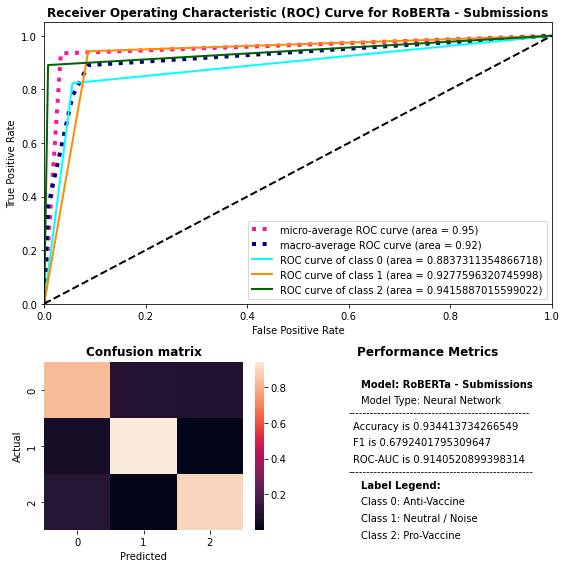

In [18]:
plot_results_b(df.label, df.pred_1, 'RoBERTa - Submissions', "Neural Network")

In [3]:
y_true = pd.read_csv('../../Files/models/y_true.csv')

In [4]:

y_true.reset_index(drop=True, inplace=True)
y_true = y_true.to_numpy()
y_true = y_true.flatten()

## Explainable Models

### Linear Regression

In [92]:
y_pred = np.loadtxt('../../Files/models/lr_pred.csv', delimiter=',')

Model performance for Logistic Regression
------------------------------------------------
Accuracy is  0.4772888956416661
F1 is  0.2892851572138753
ROC AUC Score is  0.5812123965475927
------------------------------------------------


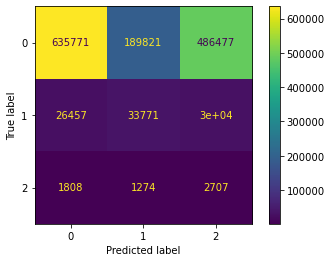

In [100]:
plot_results(y_true, y_pred, 'Logistic Regression')

### XGBoost

In [102]:
y_pred = np.fromfile('../../Files/models/xgb_test.txt', sep=' ')

In [104]:
y_pred.shape

(1408474,)

Model performance for XGBoost
------------------------------------------------
Accuracy is  0.8608841909754813
F1 is  0.53970939527811
ROC AUC Score is  0.8576378919397051
------------------------------------------------


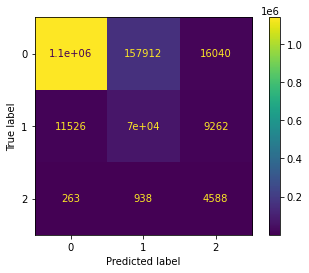

In [105]:
plot_results(y_true, y_pred, 'XGBoost')

## Neural Networks

### CNN

In [112]:
y_pred = np.loadtxt('../../Files/models/cnn_results.txt')

In [115]:
y_pred[0:10]

array([9.99912977e-01, 7.27573497e-05, 1.42607951e-05, 9.78811800e-01,
       1.94173157e-02, 1.77089276e-03, 9.99758661e-01, 1.86581878e-04,
       5.46742085e-05, 1.55724501e-06])

In [116]:
y_pred = y_pred.reshape(1408474, 3)

In [119]:
y_pred = y_pred.round()

In [121]:
y_pred = np.argmax(y_pred, axis=1)

array([0, 0, 0, 2, 0, 0, 0, 1, 0, 0])

Model performance for CNN
------------------------------------------------
Accuracy is  0.8999498748290703
F1 is  0.5749161834943711
ROC AUC Score is  0.8847233525388848
------------------------------------------------


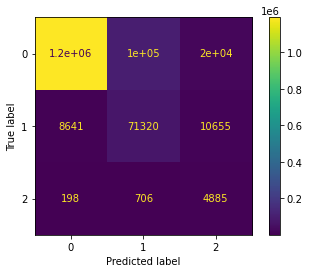

In [123]:
plot_results(y_true, y_pred, 'CNN')

In [37]:
y_pred = np.loadtxt('../../Files/models/cnn_results2.txt')

Model performance for CNN
------------------------------------------------
Accuracy is  0.8892517717756948
F1 is  0.5507019956386668
ROC AUC Score is  0.8728806283654875
------------------------------------------------


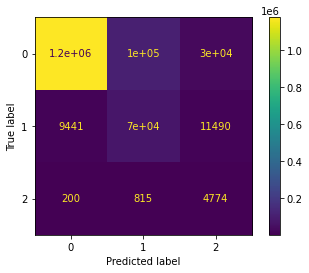

In [38]:
y_pred = y_pred.reshape(1408474, 3)
y_pred = y_pred.round()
y_pred = np.argmax(y_pred, axis=1)
plot_results(y_true, y_pred, 'CNN')

### Pre-trained BERT: BERT base cased

In [2]:
df = pd.read_pickle('../../Files/models/bert_base_cased_model/fully_trained/bert_base_cased_predictions.pickle')

In [12]:
y_pred = []

In [14]:
for i, j in df.iterrows():
    y_pred.append(df[0][i]['label'][-1])

In [21]:
y_pred = np.array(y_pred)

In [26]:
y_pred = [int(x) for x in y_pred]

In [27]:
type(y_pred[0])

int

Model performance for BERT
------------------------------------------------
Accuracy is  0.9042864831015694
F1 is  0.593250898842808
ROC AUC Score is  0.9015098483658733
------------------------------------------------


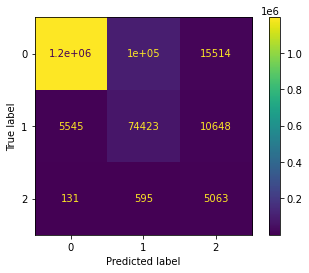

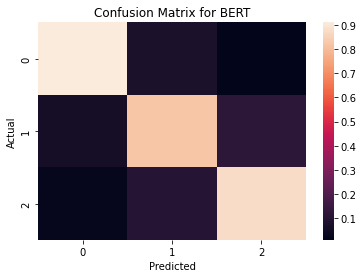

In [60]:
plot_results(y_true, y_pred, 'BERT')

In [10]:
df[0][2]['label'][-1]

'0'

In [25]:
df = pd.read_pickle('../../Files/models/bert_base_cased_model/fully_trained/bert_base_cased_predictions2.pickle')

In [26]:
df.head()

,0
0,"{'label': 'LABEL_0', 'score': 0.9984500408172607}"
1,"{'label': 'LABEL_0', 'score': 0.9241588115692139}"
2,"{'label': 'LABEL_0', 'score': 0.9884061813354492}"
3,"{'label': 'LABEL_2', 'score': 0.718645453453064}"
4,"{'label': 'LABEL_0', 'score': 0.9409974217414856}"


In [37]:
label = []
confidence = []
for i, j in df.iterrows():
    label.append(df[0][i]['label'][-1])
    confidence.append(df[0][i]['score'])

# y_pred = np.array(y_pred)
label = [int(x) for x in label]

In [38]:
df3 = pd.DataFrame({'prediction': label, 'confidence': confidence, 'actual': y_true})

In [39]:
df3['correct'] = df3['prediction'] == df3['actual']

<AxesSubplot:>

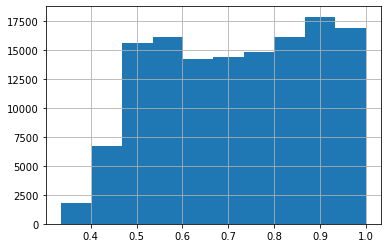

In [50]:
df3[df3['correct']== False].confidence.hist()

In [51]:
df4 = df3[df3['correct']== False]

In [52]:
len(df4)

134810

In [53]:
df4.groupby('prediction').count()

,confidence,actual,correct
prediction,,,
0,5676,5676,5676
1,102972,102972,102972
2,26162,26162,26162


In [54]:
df5 = df4[df4['prediction'] == 1]

In [55]:
df5.groupby('actual').count()

,prediction,confidence,correct
actual,,,
0,102377,102377,102377
2,595,595,595


<AxesSubplot:>

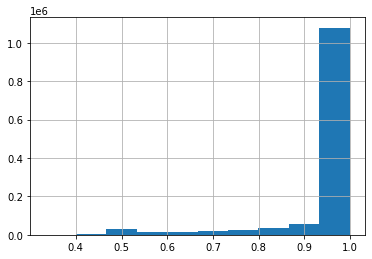

In [48]:
df3[df3['correct']== True].confidence.hist()

Model performance for BERT
------------------------------------------------
Accuracy is  0.9042864831015694
F1 is  0.593250898842808
ROC AUC Score is  0.9015098483658733
------------------------------------------------


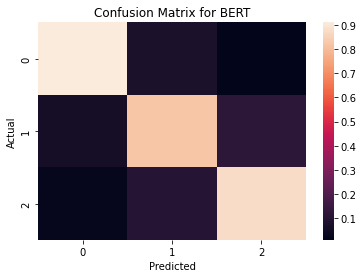

In [23]:
plot_results(y_true, y_pred, 'BERT')

### pre-trained Twitter RoBERTa Submissions

In [6]:
df = pd.read_pickle('/Users/jakobschlierf/Desktop/Master/Thesis/Files/models/chp43125s.pickle')

Model performance for RoBERTa - Submissions
------------------------------------------------
Accuracy is  0.934413734266549
F1 is  0.6792401795309647
ROC AUC Score is  0.9140520899398314
------------------------------------------------


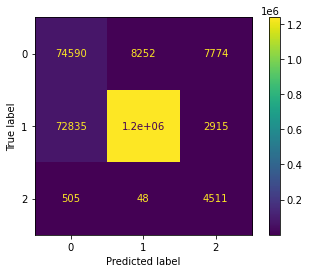

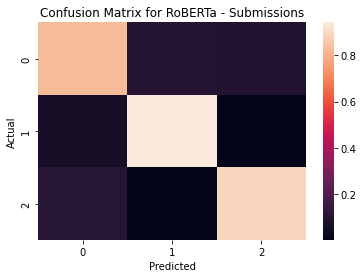

In [13]:
plot_results(df.label, df.pred_1, 'RoBERTa - Submissions')

AttributeError: 'Text' object has no property 'bold'

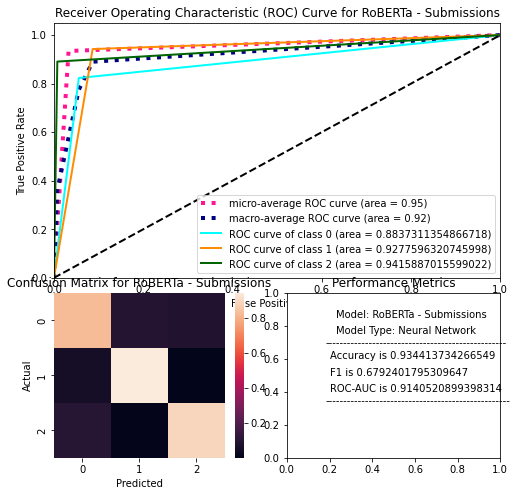

In [8]:
plot_results_b(df.label, df.pred_1, 'RoBERTa - Submissions', "Neural Network")

In [ ]:
# all imports
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.datasets import  make_classification
from sklearn.ensemble import RandomForestClassifier


In [33]:
y_test = df.label.values
y_pred = df.pred_1.values

In [45]:
n_classes = len(np.unique(y_test))
y_test = label_binarize(y_test, classes=np.arange(n_classes))
y_pred = label_binarize(y_pred, classes=np.arange(n_classes))
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
thresholds = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_test[:, i], y_pred[:, i], drop_intermediate=False)
roc_auc[i] = auc(fpr[i], tpr[i])


In [46]:
roc_auc

{2: 0.9415887015599022}

In [28]:
y_pred

array([1., 1., 1., ..., 1., 1., 1.])

In [27]:
y_test

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])

<Figure size 720x360 with 0 Axes>

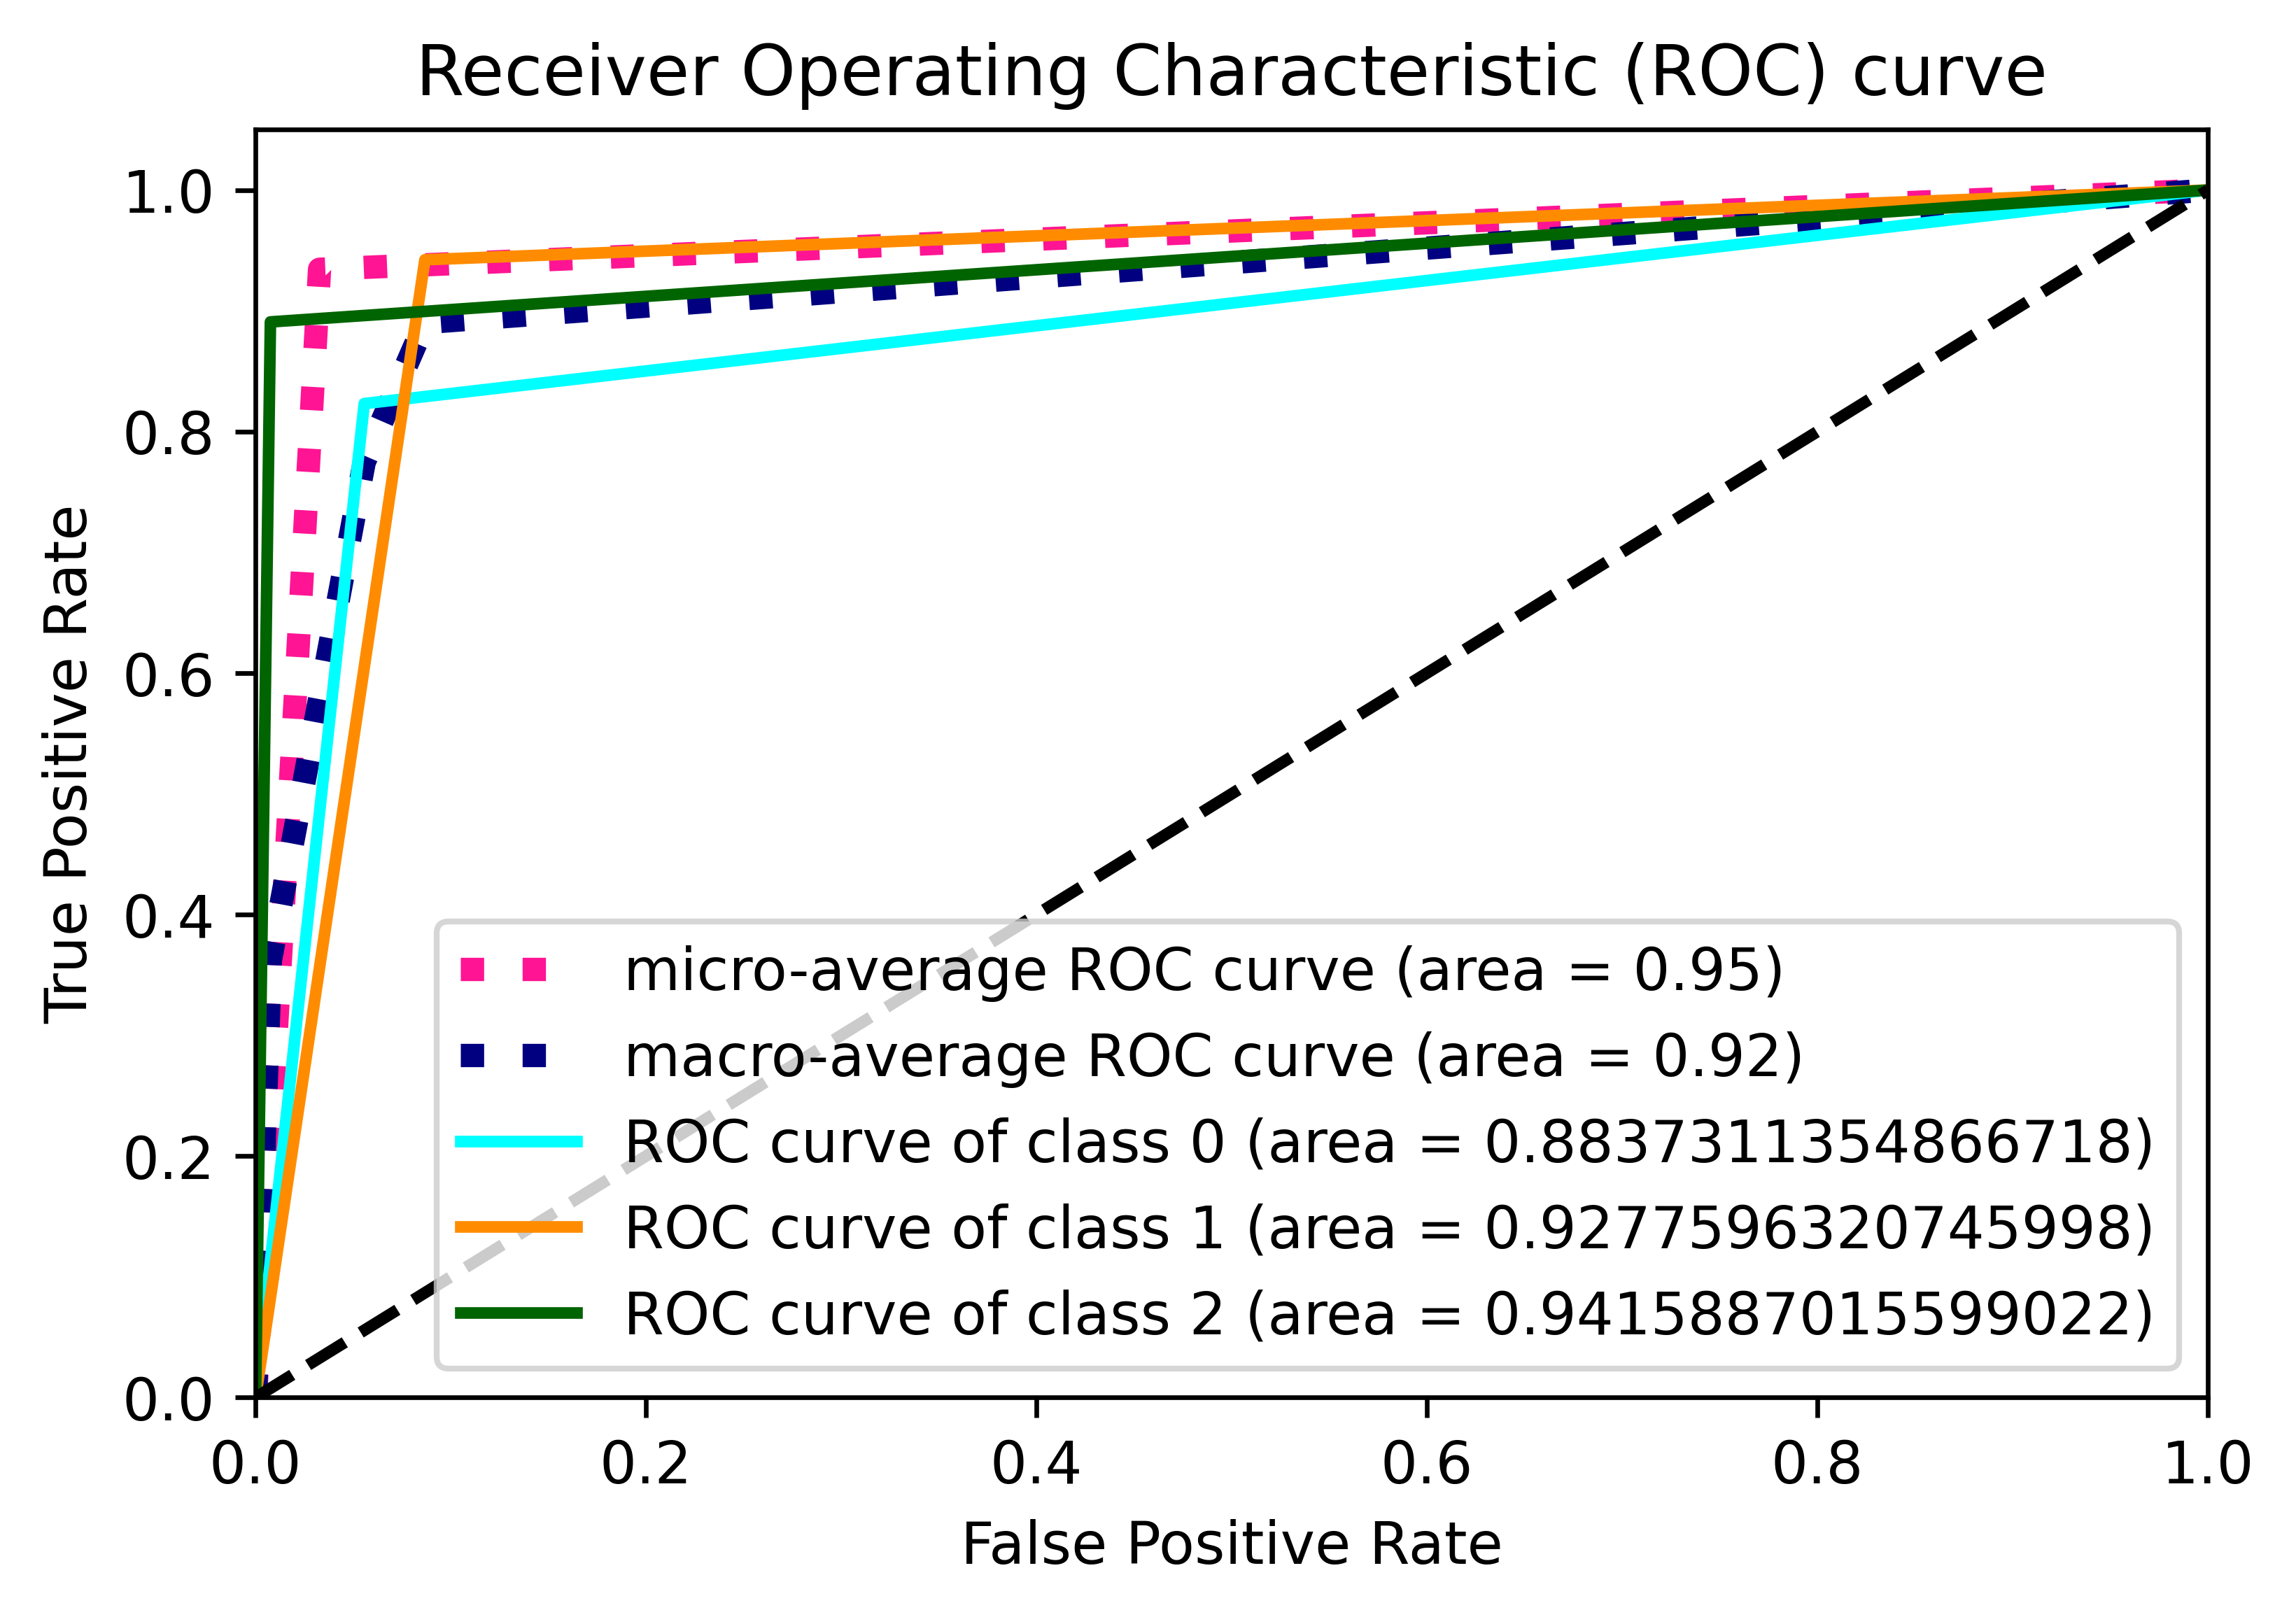

In [50]:
plot_roc_curve(df.label.values, df.pred_1.values)

### pre-trained Twitter RoBERTa Comments

In [40]:
df2 = pd.read_pickle('/Users/jakobschlierf/Desktop/Master/Thesis/Files/models/chp63750.pickle')

Model performance for RoBERta - Comments
------------------------------------------------
Accuracy is  0.7482533536850204
F1 is  0.49570891511354587
ROC AUC Score is  0.7786089266048527
------------------------------------------------


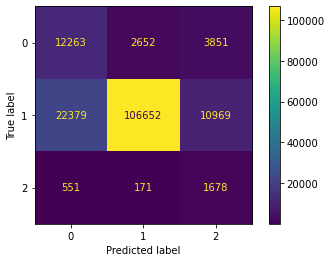

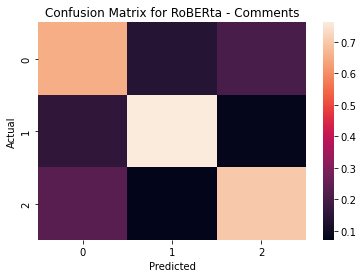

In [16]:
plot_results(df2.label, df2.pred_1, 'RoBERta - Comments')

<Figure size 720x360 with 0 Axes>

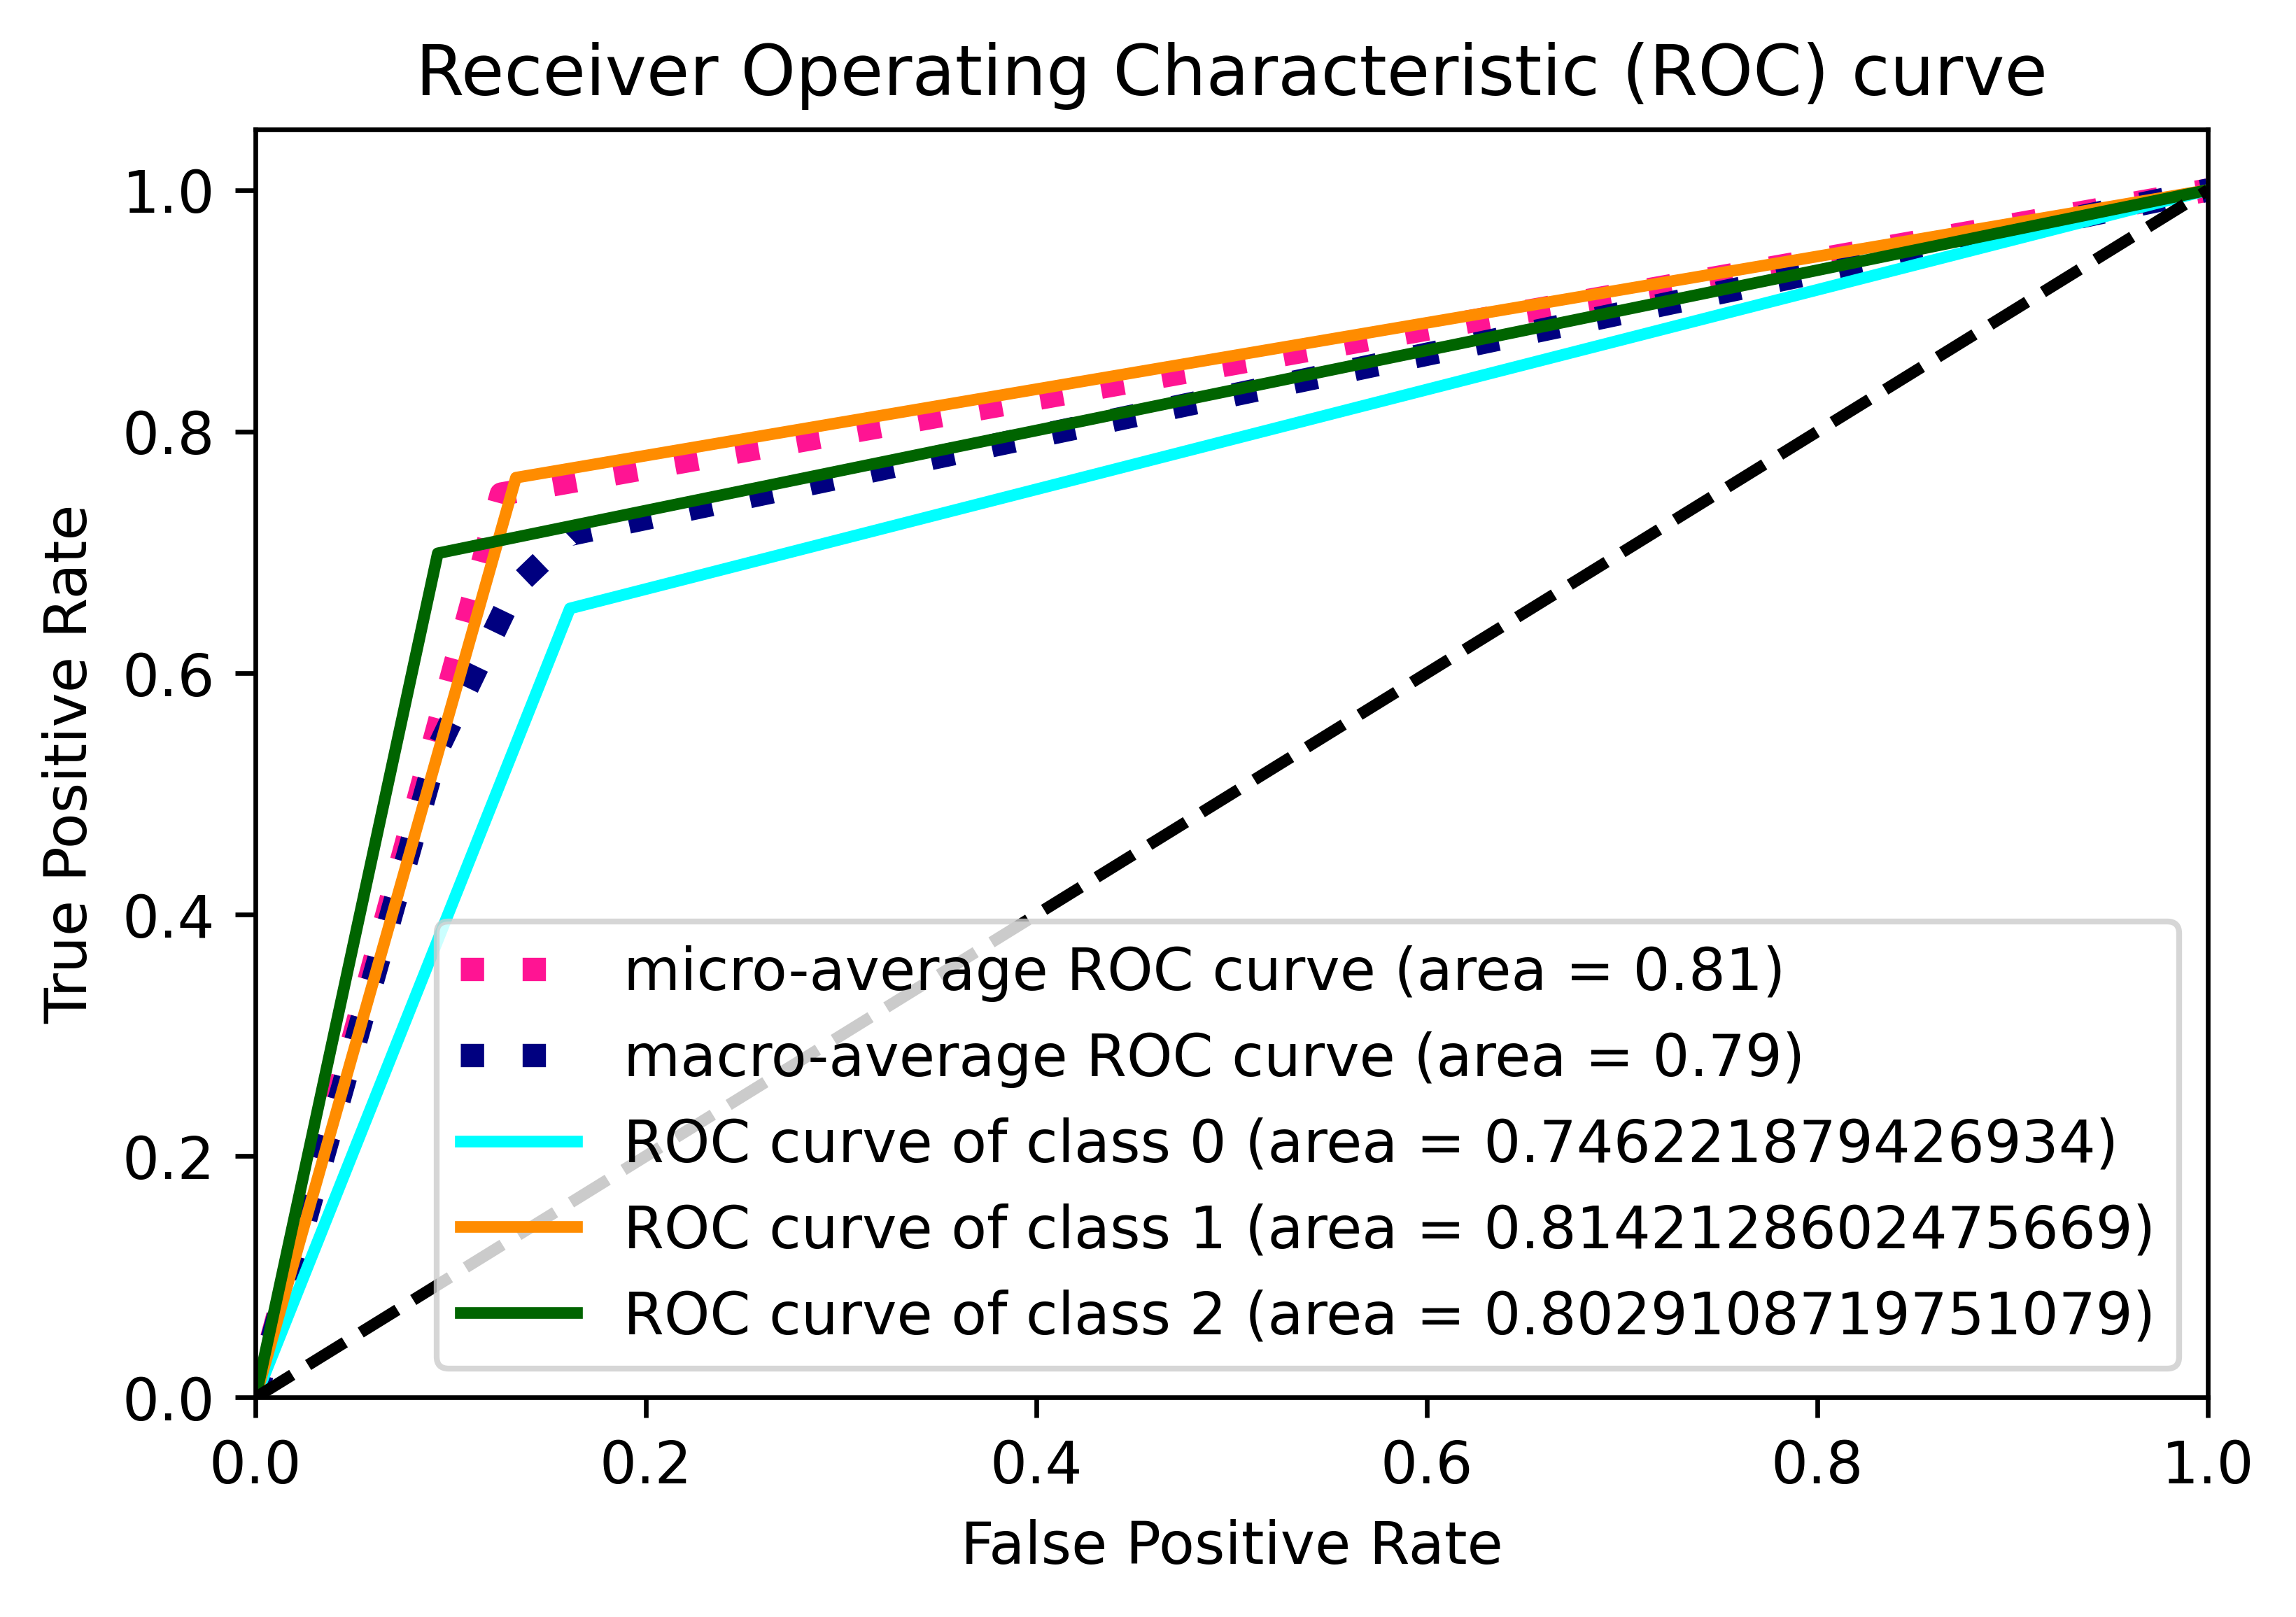

In [51]:
plot_roc_curve(df2.label.values, df2.pred_1.values)

In [3]:
df3 = pd.read_pickle('../../Files/models/chp43125c.pickle')

Model performance for RoBERta - trained on posts, used for Comments
------------------------------------------------
Accuracy is  0.6958725785835722
F1 is  0.4633986622174089
ROC AUC Score is  0.7342723134036734
------------------------------------------------


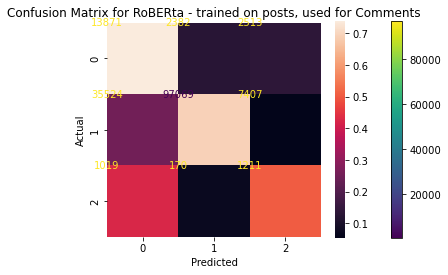

In [4]:
plot_results(df3.label, df3.pred_1, 'RoBERta - trained on posts, used for Comments')

<Figure size 720x360 with 0 Axes>

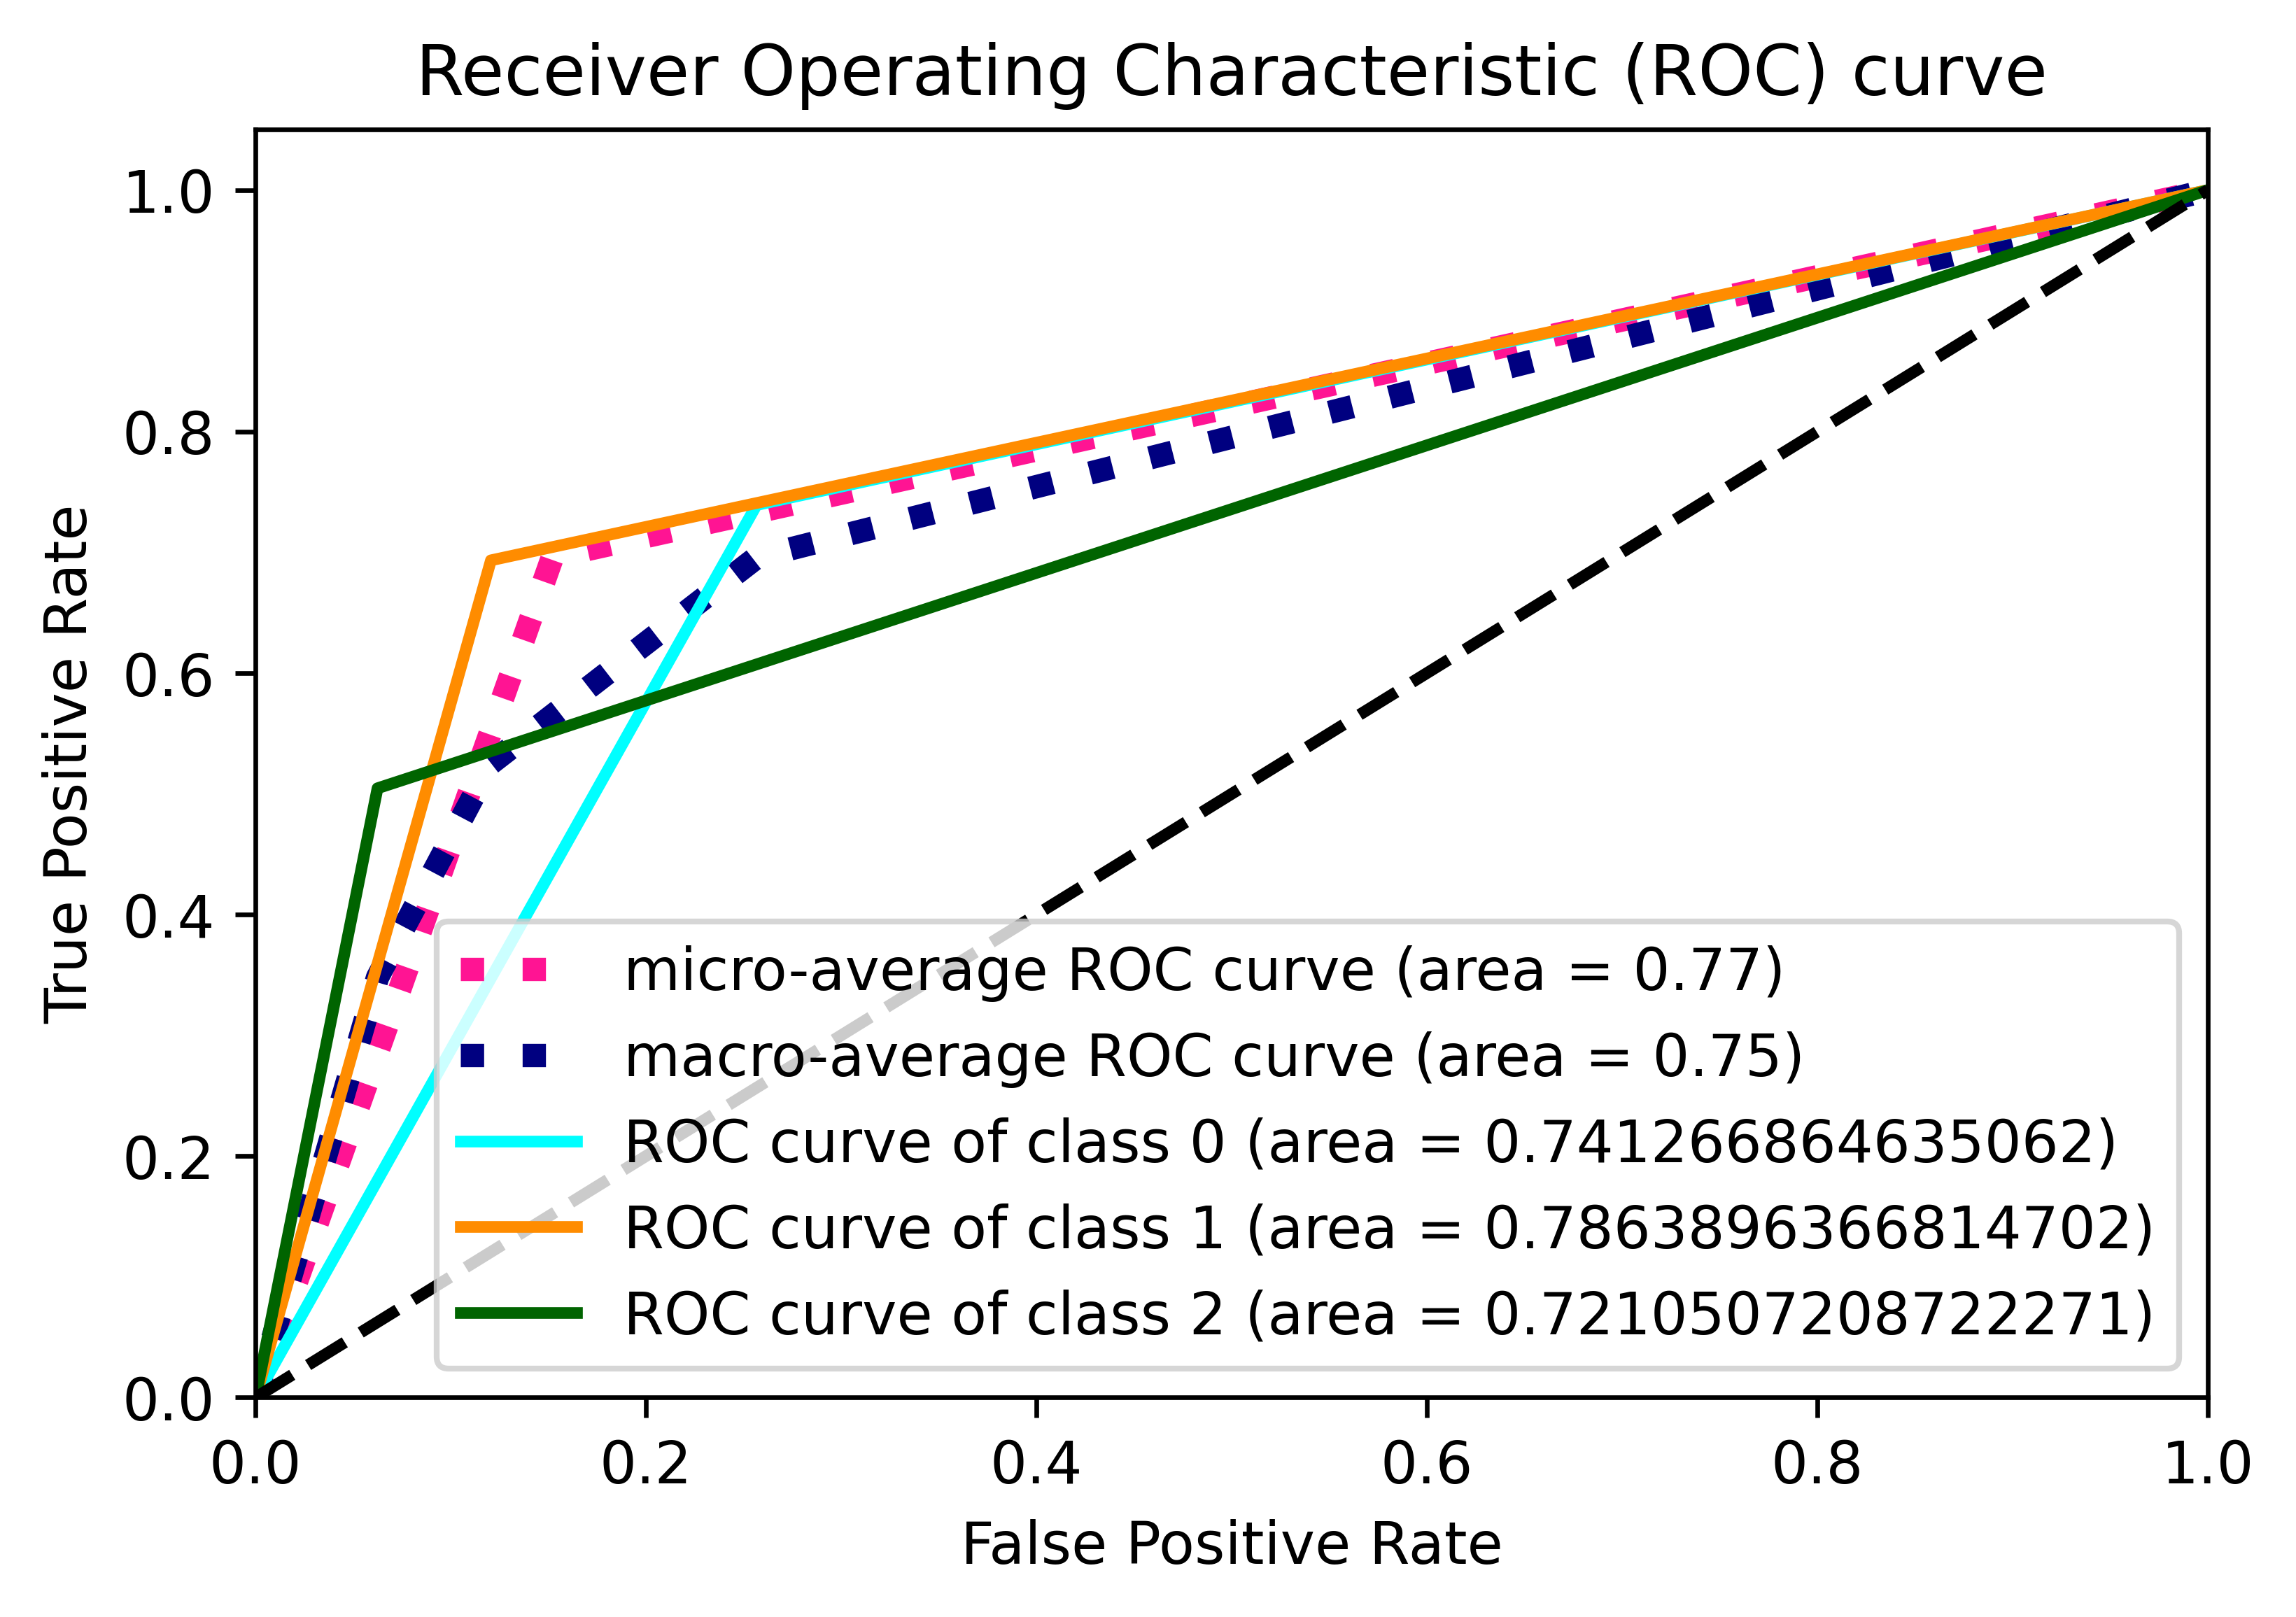

In [52]:
plot_roc_curve(df3.label.values, df3.pred_1.values)